<center>  <h1> Lecture 3: Convolutions </h1> </center> 
<center> Krishna Pillutla, Zaid Harchaoui </center>
    <center> Data 598 (Winter 2022), University of Washington </center>

In this demo, we will talk about convolutions in the context of images. 

Recall that a multilayer perceptron (MLP), which interleaved linear maps with non-linear activations, required us to flatten an image. That destroys the spatial structure of the image. 

A natural way to preserve spatial structure of images to perform a different linear operation known as the convolution. A neural network obtained with convolutions as (some of) the linear maps is a convolutional neural network. 

In this demo, we will motivate the convolution by using a related notion of a *correlation filter*.



**What is a convolution?**

Consider an image $I$ denoted by a matrix of size $m \times n$. 
We typically convolve an image with what is known as a convolutional kernel or filter $k$, 
which is denoted as a matrix. For convenience, we let $k$ be of size $(2m'+1) \times (2n' + 1)$.
Typically, we have, $m' \ll m, n' \ll n$ and that the kernel matrix's dimensions $2m'+1, 2n'+1$ are odd integers. 

The convolution of an image $I$ with kernel $k$, denoted $I \star k$, is defined as 
$$
    (I \star k)[x, y] =  \sum_{a=-m'}^{m'} \sum_{b=-n'}^{n'} k[a, b] \, I[x + a, y + b]
$$
where we index $k$ from $-m'$ to $m'$ and $-n'$ to $n'$ for convenience. 

The GIF below (source [here](https://miro.medium.com/max/700/1*Fw-ehcNBR9byHtho-Rxbtw.gif)) shows a $3 \times 3$ convolution on a image.

<img src="https://miro.medium.com/max/700/1*Fw-ehcNBR9byHtho-Rxbtw.gif" width="500">

Let us illustrate the action of a simple kernel, which computes how different a pixel is from its four neighbors. In particular, we use the kernel
$$
    k = \begin{pmatrix} 0 & -1 & 0 \\ -1 & 4 & -1 \\ 0 & -1 & 0 \end{pmatrix} .
$$
When convolved with this kernel, note that the $(x, y)$ pixel is 
$$
    (I \star k)[x, y] = 4 I[x, y] - I[x+1, y] - I[x-1, y] - I[x, y+1] - I[x, y-1].
$$
This kernel detects sudden changes in pixel values, in other words, edges. 

In [8]:
from PIL import Image
from scipy.signal import correlate
import numpy as np
import requests
from io import BytesIO

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

convolutional kernel =
 [[ 0 -1  0]
 [-1  4 -1]
 [ 0 -1  0]]


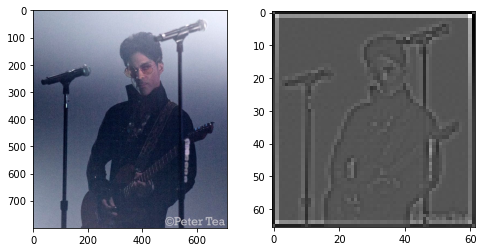

In [31]:
image_url = "https://live.staticflickr.com/6001/5932635601_482f3e58d7_c.jpg"  # Give your own!

# Load image
r = requests.get(image_url, stream=True)
image = Image.open(BytesIO(r.content))

# Convert to grayscale (Convolutions in color works much the same way)
image_graysacle = image.convert('L').resize((60, 64), Image.BILINEAR)

f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(image, cmap='gray')
kernel =  np.asarray([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

print("convolutional kernel =\n", kernel)

convolved_image = correlate(image_graysacle, kernel)
ax[1].imshow(convolved_image, cmap='gray')

## Convolutions as correlations

The convolution operation we have defined above is also know as a **correlation filter**. A correlation filter searches through the various patches of an image and produces a peak when a patch resembles the filter. 

**Note**: Strictly speaking, the mathematical definitions of a *convolution* and a *correlation filter* differ in flipping the kernel. With some abuse of nomenclature, we will use these terms interchangeably. 

<div>
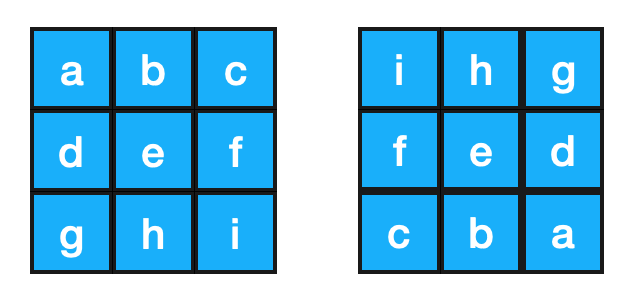
</div>


### Dataset and Task
For this part, we will use use the LFW dataset (Labeled Faces in the Wild). We will try to create a lightweight "nose detector" in images. 

In [32]:
import torch
import numpy as np
import sklearn.datasets

In [36]:
# Download dataset
dataset = sklearn.datasets.fetch_lfw_people(data_home='./data')  # downloads dataset (350 MB), takes a few minutes
images = dataset.images
labels = dataset.target
print(images.shape)  # 13233 gray scale images of size 62 x 47

(13233, 62, 47)


Let us visualize some images now. 

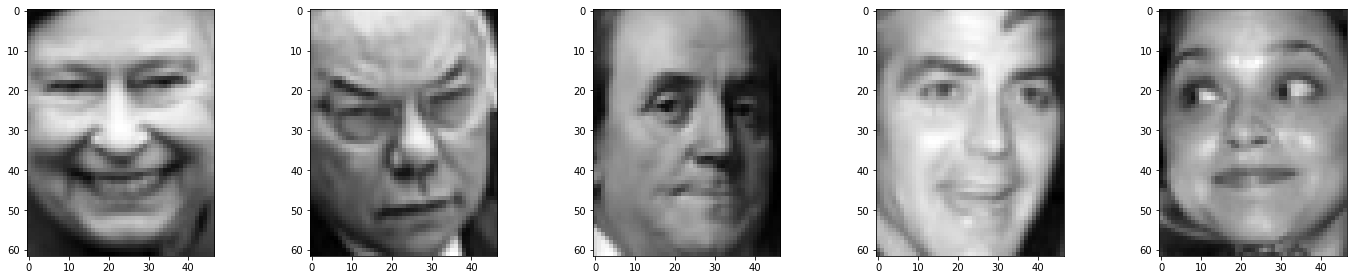

In [37]:
f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    ax[i].imshow(images[np.random.randint(images.shape[0])], cmap='gray')
plt.tight_layout()

Let us select all the images of one person, Serena Williams. 

In [41]:
selected_label = 4963 # the label corresponding to Serena Williams 
selected_images = images[labels==selected_label]
print(selected_images.shape)  # 52 images

(52, 62, 47)


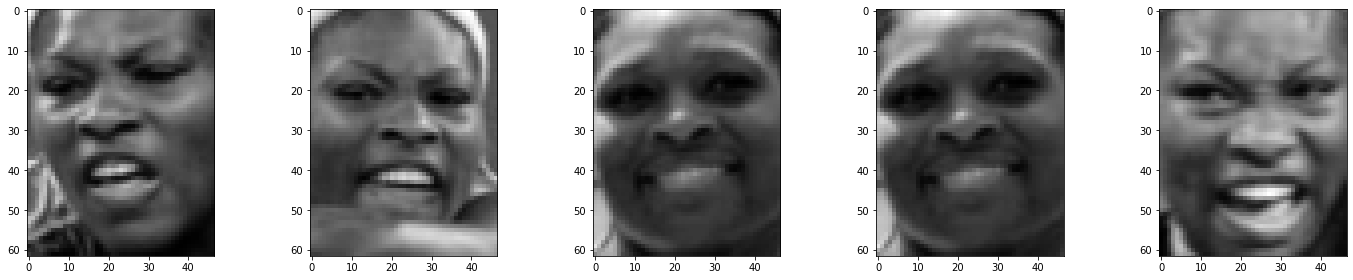

In [30]:
f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    ax[i].imshow(selected_images[np.random.randint(selected_images.shape[0])], cmap='gray')
plt.tight_layout()

We will try to build a "nose detector" using an image of Serena's nose as a filter. 

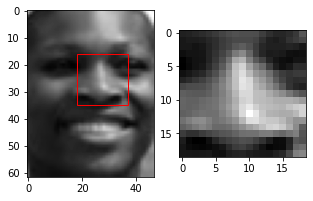

In [33]:
f, ax = plt.subplots(1, 2, figsize=(5, 4))
image = selected_images[2]
ax[0].imshow(image, cmap='gray')

y, x, h, w = 16, 18, 19, 19
rect = mpl.patches.Rectangle((x,y),h,w,linewidth=1,edgecolor='r',facecolor='none')
ax[0].add_patch(rect)

patch = image[y:y+h, x:x+w]
ax[1].imshow(patch, cmap='gray')

We center each path and make it unit norm. This is to account for varying levels of brightness and contrast in the images. 

Let us code up the correlation filter now. We iterate over each patch (of a given size) in the image and compute its dot product with the filter. 
Let us see if the image of a nose can use used to identify noses in other images of Serena with different angles, lighting and expressions.

In [34]:
def center_image(image):  
    # normalize to reduce effects of brightness and contrast
    image = image - image.mean()
    return image / np.linalg.norm(image.reshape(-1))

In [36]:
def correlation_filter(image, patch):
    h, w = image.shape
    h1, w1 = patch.shape
    output = np.zeros((h-h1+1, w-w1+1))
    for i in range(h-h1+1):
        for j in range(w-w1+1):
            image1 = center_image(image[i:i+h1, j:j+w1]).reshape(-1)
            patch1 = center_image(patch.reshape(-1))
            output[i, j] = np.dot(patch1, image1)  

    # embed output in the center of an image and zero pad it
    new_output = np.zeros_like(image)
    new_output[h1//2:h1//2+output.shape[0], w1//2:w1//2+output.shape[1]] = output
    return new_output

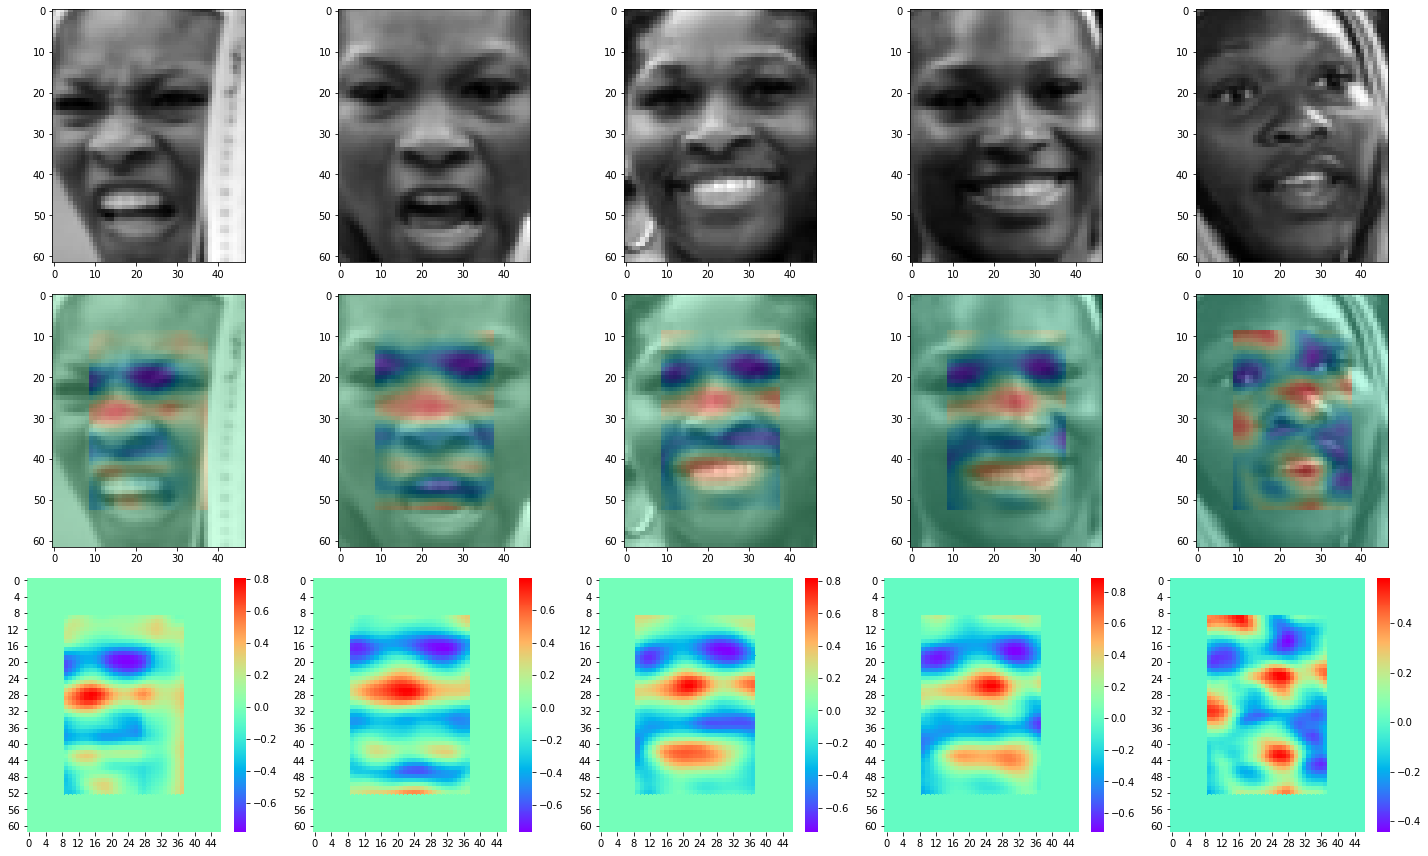

In [37]:
f, ax = plt.subplots(3, 5, figsize=(20, 12))
for i in range(5):
    img = selected_images[np.random.randint(selected_images.shape[0])]
    ax[0, i].imshow(img, cmap='gray')
    ax[1, i].imshow(img, cmap='gray')
    mask = correlation_filter(center_image(img), patch)
    # mask = correlation_filter((img - mean)/std, patch)
    ax[1, i].imshow(mask, alpha=0.4, cmap='rainbow')
    # ax[2, i].imshow(mask, cmap='rainbow')  # does not show colorbar
    sns.heatmap(mask, ax=ax[2, i], cmap='rainbow')
plt.tight_layout()

Let us check if our "nose detector" works on images of completely different people.

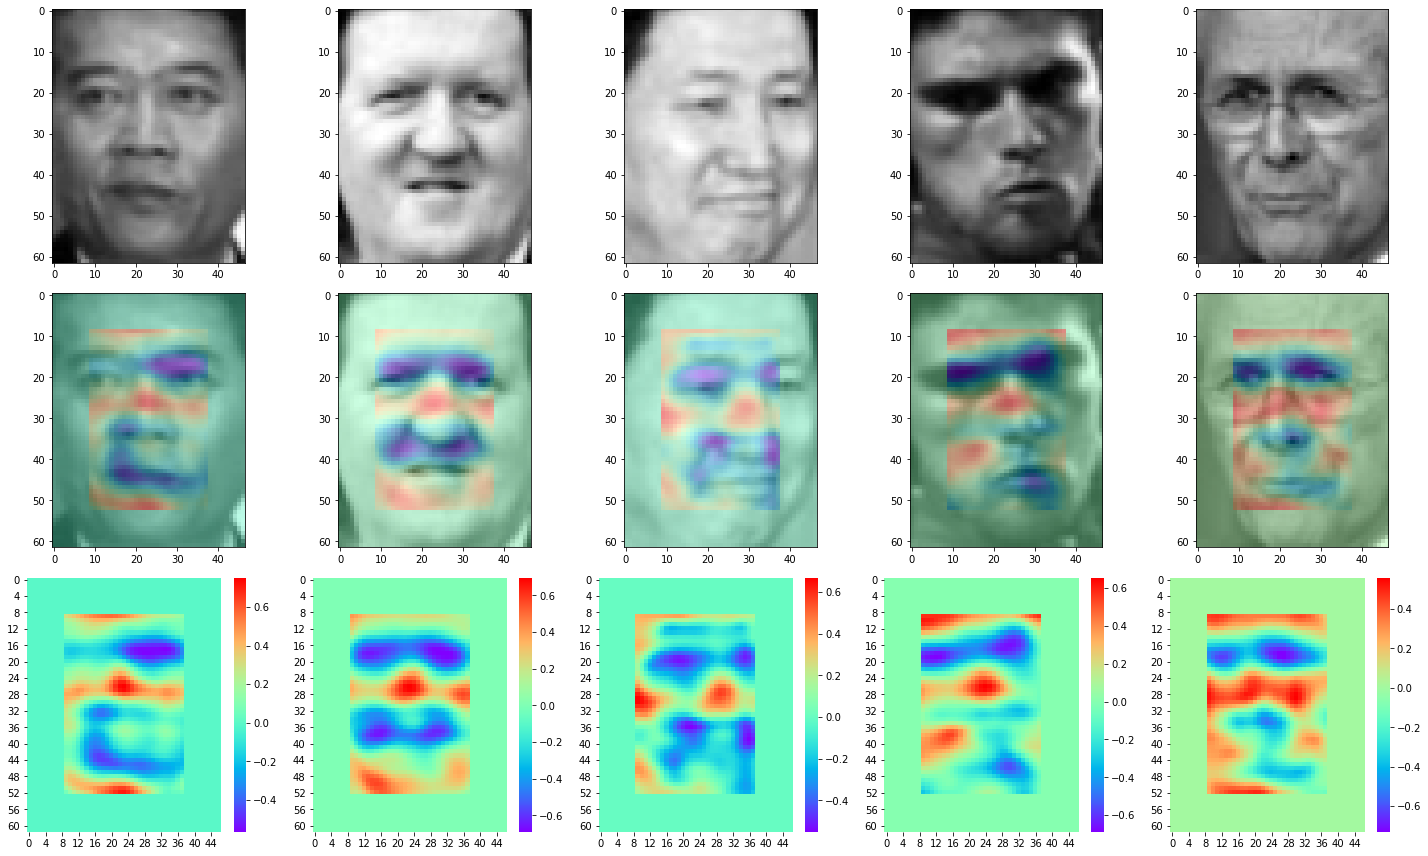

In [39]:
f, ax = plt.subplots(3, 5, figsize=(20, 12))
for i in range(5):
    img = images[np.random.randint(images.shape[0])]
    ax[0, i].imshow(img, cmap='gray')
    ax[1, i].imshow(img, cmap='gray')
    mask = correlation_filter(center_image(img), patch)
    # mask = correlation_filter((img - mean)/std, patch)
    ax[1, i].imshow(mask, alpha=0.4, cmap='rainbow')
    # ax[2, i].imshow(mask, cmap='rainbow')  # does not show colorbar
    sns.heatmap(mask, ax=ax[2, i], cmap='rainbow')
plt.tight_layout()

Let us redo this exercise to build an "eye detector".

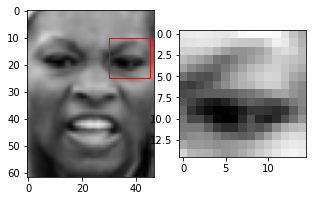

In [40]:
f, ax = plt.subplots(1, 2, figsize=(5, 4))
image = selected_images[16]
ax[0].imshow(image, cmap='gray')

# Create a Rectangle patch
y, x, h, w = 10, 30, 15, 15
rect = mpl.patches.Rectangle((x,y),h,w,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax[0].add_patch(rect)

patch = image[y:y+h, x:x+w]
ax[1].imshow(patch, cmap='gray')

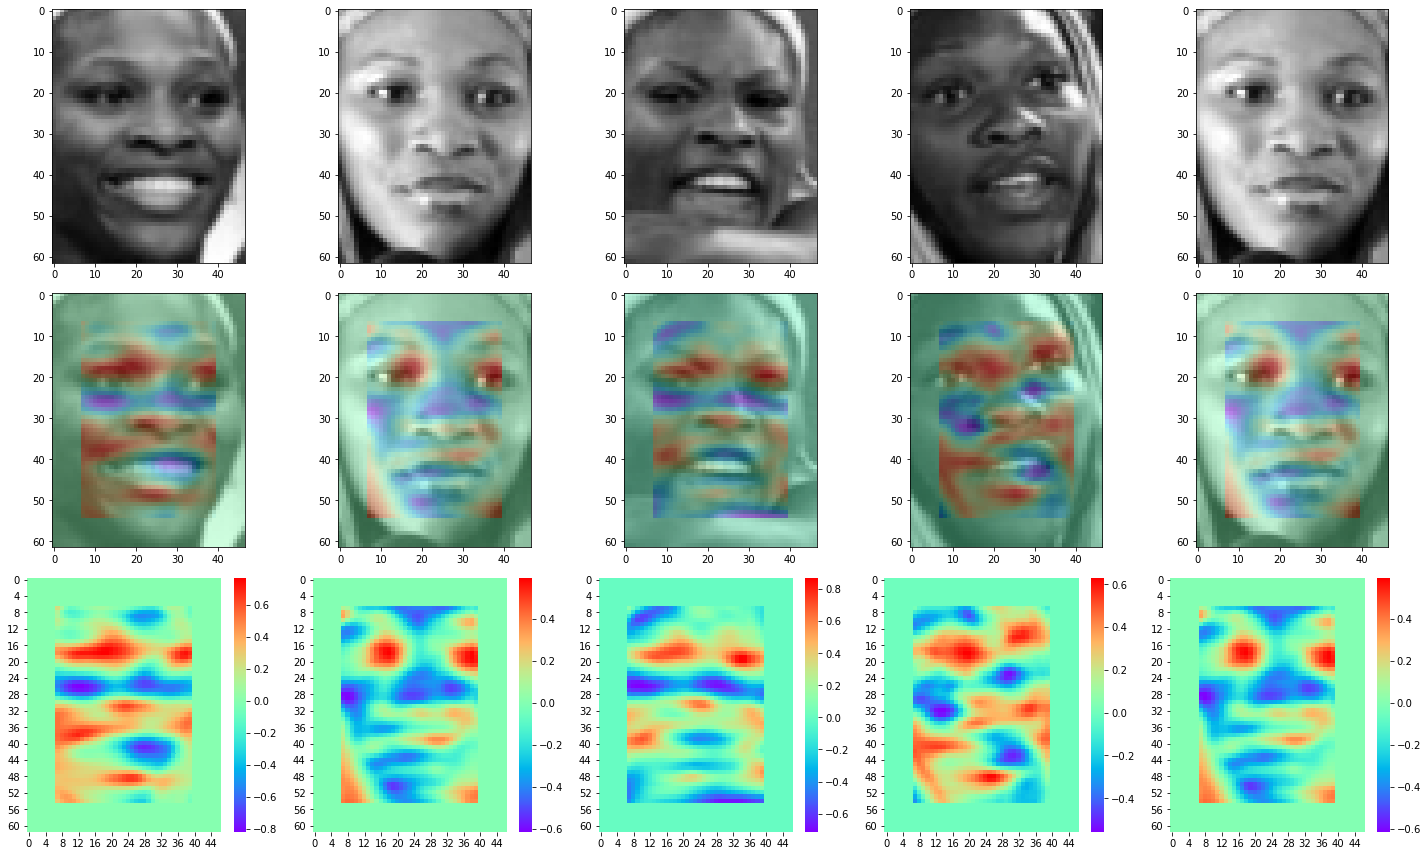

In [41]:
f, ax = plt.subplots(3, 5, figsize=(20, 12))
for i in range(5):
    img = selected_images[np.random.randint(selected_images.shape[0])]
    ax[0, i].imshow(img, cmap='gray')
    ax[1, i].imshow(img, cmap='gray')
    mask = correlation_filter(center_image(img), patch)
    # mask = correlation_filter((img - mean)/std, patch)
    ax[1, i].imshow(mask, alpha=0.4, cmap='rainbow')
    #ax[2, i].imshow(mask, cmap='rainbow') # does not show colorbar
    sns.heatmap(mask, ax=ax[2, i], cmap='rainbow')
plt.tight_layout()

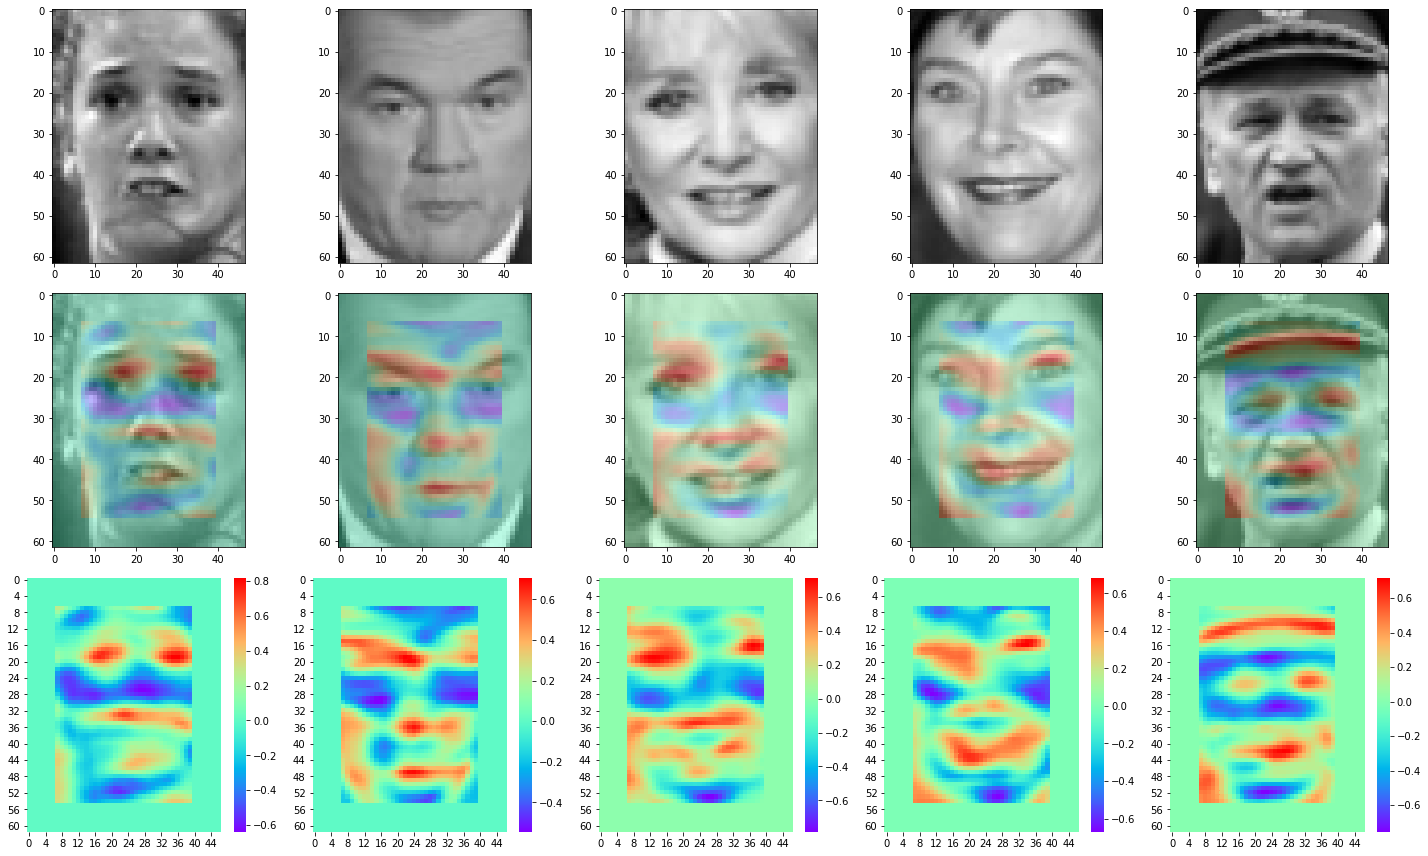

In [42]:
f, ax = plt.subplots(3, 5, figsize=(20, 12))
for i in range(5):
    img = images[np.random.randint(images.shape[0])]
    ax[0, i].imshow(img, cmap='gray')
    ax[1, i].imshow(img, cmap='gray')
    mask = correlation_filter(center_image(img), patch)
    # mask = correlation_filter((img - mean)/std, patch)
    ax[1, i].imshow(mask, alpha=0.4, cmap='rainbow')
    # ax[2, i].imshow(mask, cmap='rainbow') # does not show colorbar
    sns.heatmap(mask, ax=ax[2, i], cmap='rainbow')
plt.tight_layout()

## Visualizing kernels in a convolutional neural network

The convolutional kernels/filters in a neural network learn to identify very particular 
patterns in images, much like the simple "nose/eye detectors we saw above". 
We will now visualize some filters.

In [43]:
@torch.no_grad()
def visualize_conv_kernel(conv_layer, channel=0, nrow=8): 
    # source: https://github.com/pedrodiamel/nettutorial/blob/master/pytorch/pytorch_visualization.ipynb
    kernel = conv_layer.weight
    n, c, w, h = kernel.shape
    kernel = kernel[:, channel:channel+1, :, :]
    rows = np.min((kernel.shape[0]//nrow + 1, 64))    
    grid = torchvision.utils.make_grid(kernel, nrow=nrow, normalize=True, padding=1)
    plt.figure(figsize=(nrow,rows))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [44]:
import torchvision
model = torchvision.models.resnet50(pretrained=True)

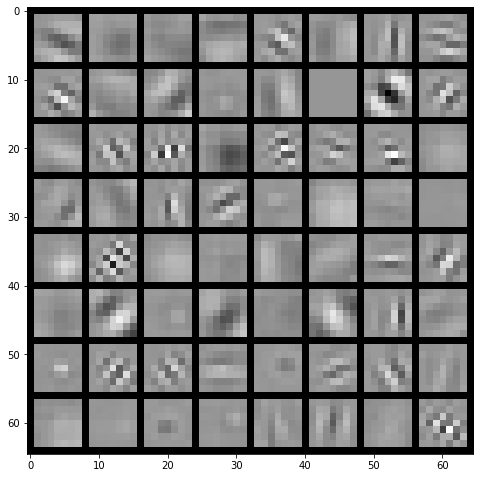

In [49]:
visualize_conv_kernel(model.conv1, channel=2)

We can compare this to a randomly initialized model, whose kernels/filters looks like noise.

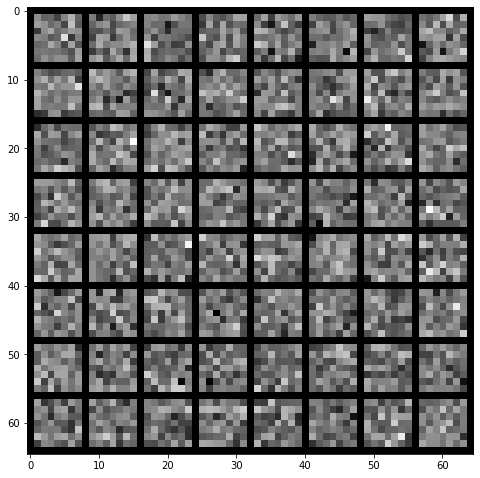

In [51]:
model2 = torchvision.models.resnet50(pretrained=False)
visualize_conv_kernel(model2.conv1, channel=1)